In [2]:
import netCDF4
import pathlib as path
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
from fnmatch import fnmatch
from typing import Iterable
import xarray as xr
from itertools import product
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [13]:
dir = '/Users/patnaude/Documents/Data/SOCRATES'

vars_to_read = ['Time','GGALT','LATC','LONC', # 4-D Position
                'UIC','VIC','WIC',            # winds
                'ATX','PSXC','EWX','RHUM',           # other state params
                ] 

#### Ideas: function to read model data to determine the grid spacing

In [19]:
def find_flight_fnames(dir_path: str) -> list[str]:
    """
    find_flight_fnames just searches a directory for all *.nc files and returns a list of them.

    :param dir_path: a path to the directory containing flight netcdf files

    :return: Returns a list of flight netcdf files.
    """
    flight_paths=[]
    flight_fnames = sorted([fname for fname in os.listdir(dir_path) if fnmatch(fname, "*.nc")])
    for i in range(len(flight_fnames)):
        flight_paths.append(dir_path + '/' + flight_fnames[i])
    
    return flight_paths


def open_nc(flight_paths: str) -> netCDF4._netCDF4.Dataset:
    """
    open_flight_nc simply checks to see if the file at the provided path string exists and opens it.

    :param file_path: A path string to a flight data file, e.g. "./test/test_flight.nc"

    :return: Returns xr.open_dataset object.
    """

    fp_path = path.Path(flight_paths)
    if not fp_path.is_file():
        raise FileNotFoundError('testing excptions')

    return xr.open_dataset(flight_paths)

def read_flight_nc_1hz(nc: xr.open_dataset, read_vars: list[str] = vars_to_read) -> pd.DataFrame:
    """
    read_flight_nc reads a set of variables into memory.

    NOTE: a low-rate, 1 Hz, flight data file is assumed

    :param nc: netCDF4._netCDF4.Dataset object opened by open_flight_nc.
    :param read_vars: An optional list of strings of variable names to be read into memory. A default
                      list, vars_to_read, is specified above. Passing in a similar list will read in those variables
                      instead.

    :return: Returns a pandas data frame.
    """

    data = [] # an empty list to accumulate Dataframes of each variable to be read in
    for var in read_vars:
        try:
            if var == "Time":
                # time is provided every second, so need to calculate 25 Hz times efficiently
                # tunits = getattr(nc[var],'units')
                # df = xr.open_dataset(nc)
                time = np.array(nc.Time)
                data.append(pd.DataFrame({var: time}))
                # dt_list = sfm_to_datetime(time, tunits)
                # data.append(pd.DataFrame({'datetime': time}))
            else:
                output = nc[var][:]
                data.append(pd.DataFrame({var: output}))
        except Exception as e:
            print(f"Issue reading {var}: {e}")
            pass
    

    # concatenate the list of dataframes into a single dataframe and return it
    return pd.concat(data, axis=1, ignore_index=False)

    

In [25]:
flight_paths = find_flight_fnames(dir)

nc = open_nc(flight_paths[2])
read_flight_nc_1hz(nc,vars_to_read)

cesm_dir = '/Users/patnaude/Documents/Data/cesmdata'

cesm = find_flight_fnames(cesm_dir)
cesm = open_nc(cesm[0])
# cesm_dat

##### Think about how to save "gridded" aircraft data, dictionary?

In [27]:
def make_grid(cesm: pd.DataFrame, air: xr.open_dataset) -> tuple[np.ndarray, dict[str, list[int]]]:
    """
    Create a grid restricted to the aircraft flight region based on CESM and flight data.

    This function reads latitude, longitude, and optionally altitude bounds from aircraft flight data,
    and creates a 3D grid over the specified region. The function assumes low-rate (1 Hz) flight 
    data and standard CESM grid data.

    :param cesm_dat: A dataset object containing CESM data with attributes like lat, lon, and lev.
    :param gv_dat: A dataset object containing aircraft data with attributes like LATC and LONC.

    :return: 
        - grid: A numpy array representing the grid restricted to the aircraft flight region.
        - bounds: A dictionary containing the calculated latitude and longitude bounds.
    """
    # Error checking for input datasets
    required_cesm_attributes = ['lat', 'lon', 'lev']
    required_gv_attributes = ['LATC', 'LONC', 'PSXC']
    
    for attr in required_cesm_attributes:
        if not hasattr(cesm, attr):
            raise ValueError(f"CESM data is missing required attribute: {attr}")
    
    for attr in required_gv_attributes:
        if not hasattr(air, attr):
            raise ValueError(f"Flight data is missing required attribute: {attr}")
    
    # Calculate latitude bounds from aircraft data
    try:
        lat_upr_bnd = int(np.abs(cesm.lat - np.max(air.LATC)).argmin())
        lat_lwr_bnd = int(np.abs(cesm.lat - np.min(air.LATC)).argmin())
    except Exception as e:
        raise ValueError(f"Error calculating latitude bounds: {e}")

    # Calculate longitude bounds from aircraft data
    try:
        lon_upr_bnd = int(np.abs(cesm.lon - np.max(air.LONC)).argmin())
        lon_lwr_bnd = int(np.abs(cesm.lon - np.min(air.LONC)).argmin())
    except Exception as e:
        raise ValueError(f"Error calculating longitude bounds: {e}")
    
    # Calculate altitude bounds from aircraft data
    try:
        alt_upr_bnd = int(np.abs(cesm.lev - np.min(air.PSXC)).argmin())
        alt_lwr_bnd = int(np.abs(cesm.lev - np.max(air.PSXC)).argmin())
    except Exception as e:
        raise ValueError(f"Error calculating altitude bounds: {e}")

    # Validate bounds: Ensure that the bounds are within the valid ranges for lat, lon, and lev
    if lat_upr_bnd >= len(cesm.lat) or lat_lwr_bnd < 0:
        raise ValueError("Latitude bounds are out of range.")
    if lon_upr_bnd >= len(cesm.lon) or lon_lwr_bnd < 0:
        raise ValueError("Longitude bounds are out of range.")
    if alt_upr_bnd >= len(cesm.lev) or alt_lwr_bnd < 0:
        raise ValueError("Altitude bounds are out of range.")

    # Store bounds for lat/lon
    bounds = {
        'lat': [lat_lwr_bnd-1, lat_upr_bnd+1],
        'lon': [lon_lwr_bnd-1, lon_upr_bnd+1],
        'palt': [alt_upr_bnd-1, alt_lwr_bnd+1]
    }

    # Create a 3D grid with dimensions (levels, latitude range, longitude range)
    grid_shape = (
        (alt_lwr_bnd+1 - alt_upr_bnd+1), 
        (lat_upr_bnd+1 - lat_lwr_bnd+1), 
        (lon_upr_bnd+1 - lon_lwr_bnd+1)
    )
    grid = np.zeros(grid_shape, dtype=int)
    return grid, bounds
    
# grid, bounds = make_grid(cesm,gv)

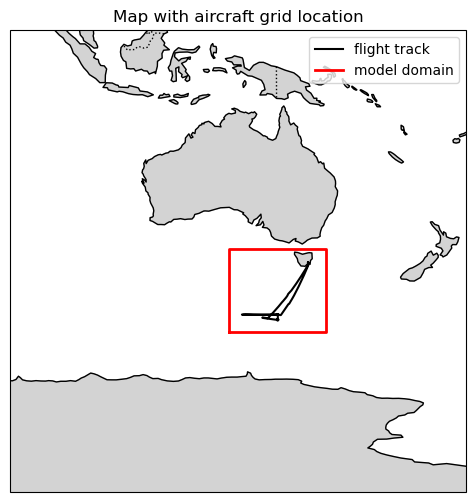

In [30]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Assuming grid and bounds are already defined

grid, bounds = make_grid(cesm, nc)

# Define the lat/lon boundaries of the square
lat_min, lat_max = float(cesm.lat[bounds['lat'][0]-1]), float(cesm.lat[bounds['lat'][1]+2])  # Latitude range
lon_min, lon_max = float(cesm.lon[bounds['lon'][0]-1]), float(cesm.lon[bounds['lon'][1]+2])  # Longitude range

# Create a plot with Cartopy's PlateCarree projection
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 6))

# Add global map features
ax.add_feature(cfeature.LAND, edgecolor='black', color='lightgray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_global()
ax.coastlines()

# Plot the flight track with proper transformation
ax.plot(nc.LONC, nc.LATC, label='flight track', color='black', transform=ccrs.PlateCarree())

# Plot the square of coordinates
square_lats = [lat_min, lat_min, lat_max, lat_max, lat_min]
square_lons = [lon_min, lon_max, lon_max, lon_min, lon_min]
ax.plot(square_lons, square_lats, color='red', linewidth=2,label='model domain', transform=ccrs.PlateCarree())

# Set the extent to zoom in on the region around the square
buffer = 45  # Degrees to add around the square for some padding
# Ensure that the longitude wrapping is handled correctly
lon_min_zoom = max(lon_min - buffer, -180)
lon_max_zoom = min(lon_max + buffer, 180)

# Set the extent for zooming in on the region around the square
ax.set_extent([lon_min_zoom, lon_max_zoom, lat_min - buffer, lat_max + buffer], crs=ccrs.PlateCarree())

# Set title
ax.set_title('Map with aircraft grid location')
ax.legend()
# Show plot
plt.show()


In [34]:
def grid_flight_dat(cesm: pd.DataFrame, air: xr.open_dataset, grid: np.ndarray, bounds: dict[str, list[int]]) -> dict:    
    """
    Grids aircraft data and scales it onto a 3D grid.

    This function maps aircraft data onto a predefined grid based on CESM data,
    using the region defined by the bounds of the flight data.

    NOTE: A low-rate, 1 Hz, flight data file is assumed.

    :param gv_dat: A dataset object containing aircraft data (e.g., LATC, LONC, U, V, T).
    :param cesm_dat: A dataset object containing CESM data (e.g., lat, lon, lev).
    :param grid: A 3D numpy array representing the grid, typically created based on flight region.
    :param bounds: A dictionary containing the latitude, longitude, and altitude bounds for the grid.

    :return: A dictionary containing latitude (lats), longitude (lons), and pressure altitude (palts)
             for grid cells where data is present.
    """
    
    mean_u = np.zeros_like(grid, dtype=float)
    mean_v = np.zeros_like(grid, dtype=float)
    mean_t = np.zeros_like(grid, dtype=float)
    
    # Generate latitude, longitude, and altitude grid values
    lats = np.array(cesm.lat[bounds['lat'][0]:bounds['lat'][1]+1])
    lons = np.array(cesm.lon[bounds['lon'][0]:bounds['lon'][1]+1])
    alts = np.array(cesm.lev[bounds['palt'][0]:bounds['palt'][1]+1])
    
    # Loop over the grid region defined by the bounds
    for i in range(0, len(alts)-1):
        for j in range(0, len(lats)-1):  # -1 to prevent out-of-bounds access
            for k in range(0, len(lons)-1):

                # Find indices of data points within the current grid cell
                grid_indices = np.where(
                    (air.LATC > lats[j]) & (air.LATC <= lats[j + 1]) &
                    (air.LONC > lons[k]) & (air.LONC <= lons[k + 1]) &
                    (air.PSXC > alts[i]) & (air.PSXC <= alts[i + 1])
                )[0]
    
                if grid_indices.size > 0:
                    mean_u[i, j, k] = np.mean(air.UIC[grid_indices])
                    mean_v[i, j, k] = np.mean(air.VIC[grid_indices])
                    mean_t[i, j, k] = np.mean(air.ATX[grid_indices])
    
    
    indices = np.argwhere(mean_t != 0)
    
    # Identify grid cells with non-zero data
    valid_indices = np.argwhere(mean_t != 0)
    alt_indices, lat_indices, lon_indices = valid_indices[:, 0], valid_indices[:, 1], valid_indices[:, 2]

    # Calculate the center values of latitude, longitude, and altitude for each grid cell
    selected_lats = (lats[lat_indices] + lats[lat_indices + 1]) / 2
    selected_lons = (lons[lon_indices] + lons[lon_indices + 1]) / 2
    selected_alts = (alts[alt_indices] + alts[alt_indices + 1]) / 2
    
    grid_dict = {'lats': selected_lats, 
                 'lons': selected_lons, 
                 'palts': selected_alts,
                 'mean_u': mean_u[mean_t !=0],
                 'mean_v': mean_v[mean_t !=0],
                 'mean_t': mean_t[mean_t !=0],
                }
    
    return grid_dict
    # print(lats,lons,alts)
# mean_t = np.argwhere(mean_grid
# grid_dict
cesm


<xarray.Dataset> Size: 2GB
Dimensions:           (lat: 192, lon: 288, lev: 32, ilev: 33, time: 1, nbnd: 2)
Coordinates:
  * lat               (lat) float64 2kB -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon               (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * lev               (lev) float64 256B 3.643 7.595 14.36 ... 957.5 976.3 992.6
  * ilev              (ilev) float64 264B 2.255 5.032 10.16 ... 985.1 1e+03
  * time              (time) object 8B 2018-02-01 00:00:00
Dimensions without coordinates: nbnd
Data variables: (12/453)
    gw                (lat) float64 2kB ...
    hyam              (lev) float64 256B ...
    hybm              (lev) float64 256B ...
    P0                float64 8B ...
    hyai              (ilev) float64 264B ...
    hybi              (ilev) float64 264B ...
    ...                ...
    soa_a2SFWET       (time, lat, lon) float32 221kB ...
    soa_a2_SRF        (time, lat, lon) float32 221kB ...
    soa_c1            (time, lev, lat, lon) float32 7MB ...
    soa_c1SFWET       (time, lat, lon) float32 221kB ...
    soa_c2            (time, lev, lat, lon) float32 7MB ...
    soa_c2SFWET       (time, lat, lon) float32 221kB ...
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              cam_cesm2_2_rel_sathist_rptest
    logname:           cmcclus
    host:              derecho5
    initial_file:      /glade/campaign/cesm/cesmdata/inputdata/atm/cam/inic/f...
    topography_file:   /glade/campaign/cesm/cesmdata/inputdata/atm/cam/topo/f...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation  

grid_data = grid_flight_dat(cesm, nc, grid, bounds)

# Create a figure
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
sc = ax.scatter(grid_data['lons'], grid_data['lats'], grid_data['palts'], c=grid_data['mean_t'], cmap='viridis', marker='^',label='grid-mean values')
# Invert the Z-axis
ax.scatter(nc.LONC, nc.LATC, nc.PSXC, c=nc.ATX, label='3D Flight track',s=12)
ax.invert_zaxis()

ax.set_xlabel('latitude (deg)')
ax.set_ylabel('longitude (deg)')
ax.set_zlabel('pressure alt (hPa)') 

ax.legend()
# # Color bar to show the mapping of color to the fourth dimension
plt.colorbar(sc, label='Mean Temperature (°C)')

# Animation function to rotate the view
def rotate(angle):
    ax.view_init(elev=30, azim=angle)

# Create animation
ani = FuncAnimation(fig, rotate, frames=np.arange(-180, 360, 5), interval=100)

# Show the animation in Jupyter Notebook
from IPython.display import HTML
HTML(ani.to_jshtml())
# Labels


# # Show the plot
# plt.show()
